In [2]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import geopandas as gp

In [3]:
def Get_FIPS(df, state):
    """
    df: DataFrame
    state: U.S. State Name (e.g. California, Idaho, etc.)
    
    Returns array of U.S. Counties' FIPS Codes.
    """
    
    state_df = df[df['state'] == state]
    fips_array = state_df['FIPS'].unique()
    
    return fips_array

def County_Winners(df, state, method='categorical'):
    """
    df: DataFrame
    state: U.S. State Name (e.g. California, Idaho, etc.)
    method: 
    
    Returns 
    """
    assert method is 'categorical' or 'continuous', "Please choose either 'categorical' or 'continuous'"
    if method is 'categorical':
        max_col = 'party'
    elif method is 'continuous':
        max_col = 'proportion'
    
    state_df = df[df['state'] == state]
    election_years = state_df['year'].unique()
    winners_container = [[] for _ in range(len(election_years))]
    
    for idx, year in enumerate(election_years):
        winners = state_df[state_df['year'] == year].groupby('FIPS').apply(
            lambda county: county[max_col][county['candidatevotes'].idxmax()]).values
        winners_container[idx] = winners
            
    return winners_container

def County_Winners_DF(df, method='categorical'):
    """
    df: 
    
    Returns 
    """
    states = df['state'].unique()
    list_counties, list_fips = [], []
    list_2000, list_2004 = [], []
    list_2008, list_2012 = [], []
    list_2016 = []
    
    for state in states:
        fips = Get_FIPS(df=df, state=state)
        county_winners = County_Winners(df=df, state=state, method=method)
        list_fips.extend(fips)
        list_2000.extend(county_winners[0])
        list_2004.extend(county_winners[1])
        list_2008.extend(county_winners[2])
        list_2012.extend(county_winners[3])
        list_2016.extend(county_winners[4])
    
    final_dataframe = pd.DataFrame({
    'FIPS': list_fips,
    '2000': list_2000, '2004': list_2004, 
    '2008': list_2008, '2012': list_2012,
    '2016': list_2016})
    
    if method is 'categorical':
        final_dataframe.replace({'republican': 1, 'democrat': 0}, inplace=True)
    else:
        pass
        
    final_dataframe['Total'] = final_dataframe.loc[:, ('2000', '2004', '2008', '2012', '2016')].sum(axis=1)
    
    return final_dataframe

In [4]:
#Datasets

states_df = pd.read_csv("4.18states.csv")
states_df = states_df[states_df['FIPS'].notna()] #Get rid of non-US "states"
states_df = states_df[states_df['FIPS']<60] #Get rid of US territories
states_df = states_df[states_df['FIPS'] != 2] #Get rid of Alaska
states_df = states_df[states_df['FIPS'] != 15] #Get rid of Hawaii
states_df['FIPS'] = states_df['FIPS'].apply(lambda x: '0'+str(int(x)) if len(str(int(x)))==1 \
                                            else str(int(x))) #Convert FIPS to String
states_df = states_df.rename(columns={'FIPS': 'STATEFP'})
STATEFP = states_df.pop('STATEFP')
states_df.insert(0, 'STATEFP', STATEFP)

counties_df = pd.read_csv("abridged_couties.csv")
counties_df = counties_df[counties_df['State'].notna()] #Get rid of US Territories
#counties_df['STATEFP'] = counties_df['STATEFP'].apply(lambda x: '0'+str(int(x)) if len(str(int(x)))==1 else str(int(x)))
counties_df = counties_df.rename(columns={'countyFIPS': 'FIPS'}) 
"""I removed the drop method here as COUNTYFP is needed for merging on US Shape File."""
#counties_df = counties_df.rename(columns={'countyFIPS': 'FIPS'}).drop(columns=['COUNTYFP'])
counties_df.loc[:, 'FIPS'] = counties_df.loc[:, 'FIPS'].astype(int, copy=False)
"""Also added this transformation of FIPS column as election data FIPS come in int/float form and I don't know 
    which counties have 0 at the start of their FIPS and whatnot."""

time_cases_df = pd.read_csv("time_series_covid19_confirmed_US.csv")
time_deaths_df = pd.read_csv("time_series_covid19_deaths_US.csv")

def clean_time_dfs(df):
    """
    This cleans time_cases & time_deaths and returns a county-level df and state-level df
    """
    df = df[df['FIPS'] >100] # Get rid of US Territories & Cruise Ships
    df = df[df['Province_State'].isin(['Diamond Princess','Grand Princess'])==False]
    df['FIPS'] = df['FIPS'].apply(lambda x: '0' + str(int(x)) if len(str(int(x)))==4 \
                                                    else str(int(x))) #Convert FIPS to string
    df['STATEFP'] = df['FIPS'].str[0:2]
    FIPS = df.pop('FIPS')
    df.insert(0, 'FIPS', FIPS)
    STATEFP = df.pop('STATEFP')
    df.insert(0, 'STATEFP', STATEFP)
    df = df[df['STATEFP'].isin(['02','15'])==False] #Get rid of Alaska & Hawaii
    #Split off "Out of [State]" & "Unassigned" Data. Remove from df
    state_df = df[df['STATEFP'].isin(['80','90'])]
    df = df[df['STATEFP'].isin(['80','90'])==False]
    return df, state_df

time_cases_df, state_time_cases = clean_time_dfs(time_cases_df)
time_deaths_df, state_time_deaths = clean_time_dfs(time_deaths_df)

---

# County Pres. 2000 - 2016

In [5]:
county_pres_df = pd.read_csv('countypres_2000-2016.csv')
county_pres_df = county_pres_df[(county_pres_df['party'] == 'democrat') | (county_pres_df['party'] == 'republican')]
county_pres_df.dropna(inplace=True)
county_pres_df = county_pres_df[(county_pres_df['county'] != 'Broomfield') & 
                                (county_pres_df['county'] != 'Kansas City') &
                                (county_pres_df['county'] != 'Bedford')]

county_pres_df.loc[:, 'proportion'] = county_pres_df.loc[:, 'candidatevotes'] / county_pres_df.loc[:, 'totalvotes']
county_pres_df.loc[::2, 'proportion'] = -county_pres_df.loc[::2, 'proportion']

shape = gp.read_file('cb_2018_us_county_5m.shp')
shape = shape.loc[:, ('STATEFP', 'COUNTYFP', 'geometry')]
shape['STATEFP'] = shape['STATEFP'].astype(float)
shape['COUNTYFP'] = shape['COUNTYFP'].astype(float)

county_winners_cat_df = County_Winners_DF(county_pres_df)
county_winners_cont_df = County_Winners_DF(county_pres_df, method='continuous')

In [6]:
county_winners_cat_df = County_Winners_DF(county_pres_df)
county_winners_cont_df = County_Winners_DF(county_pres_df, method='continuous')

In [7]:
cat_merged = counties_df.merge(county_winners_cat_df, on='FIPS', how='inner')
cont_merged = counties_df.merge(county_winners_cont_df, on='FIPS', how='inner')

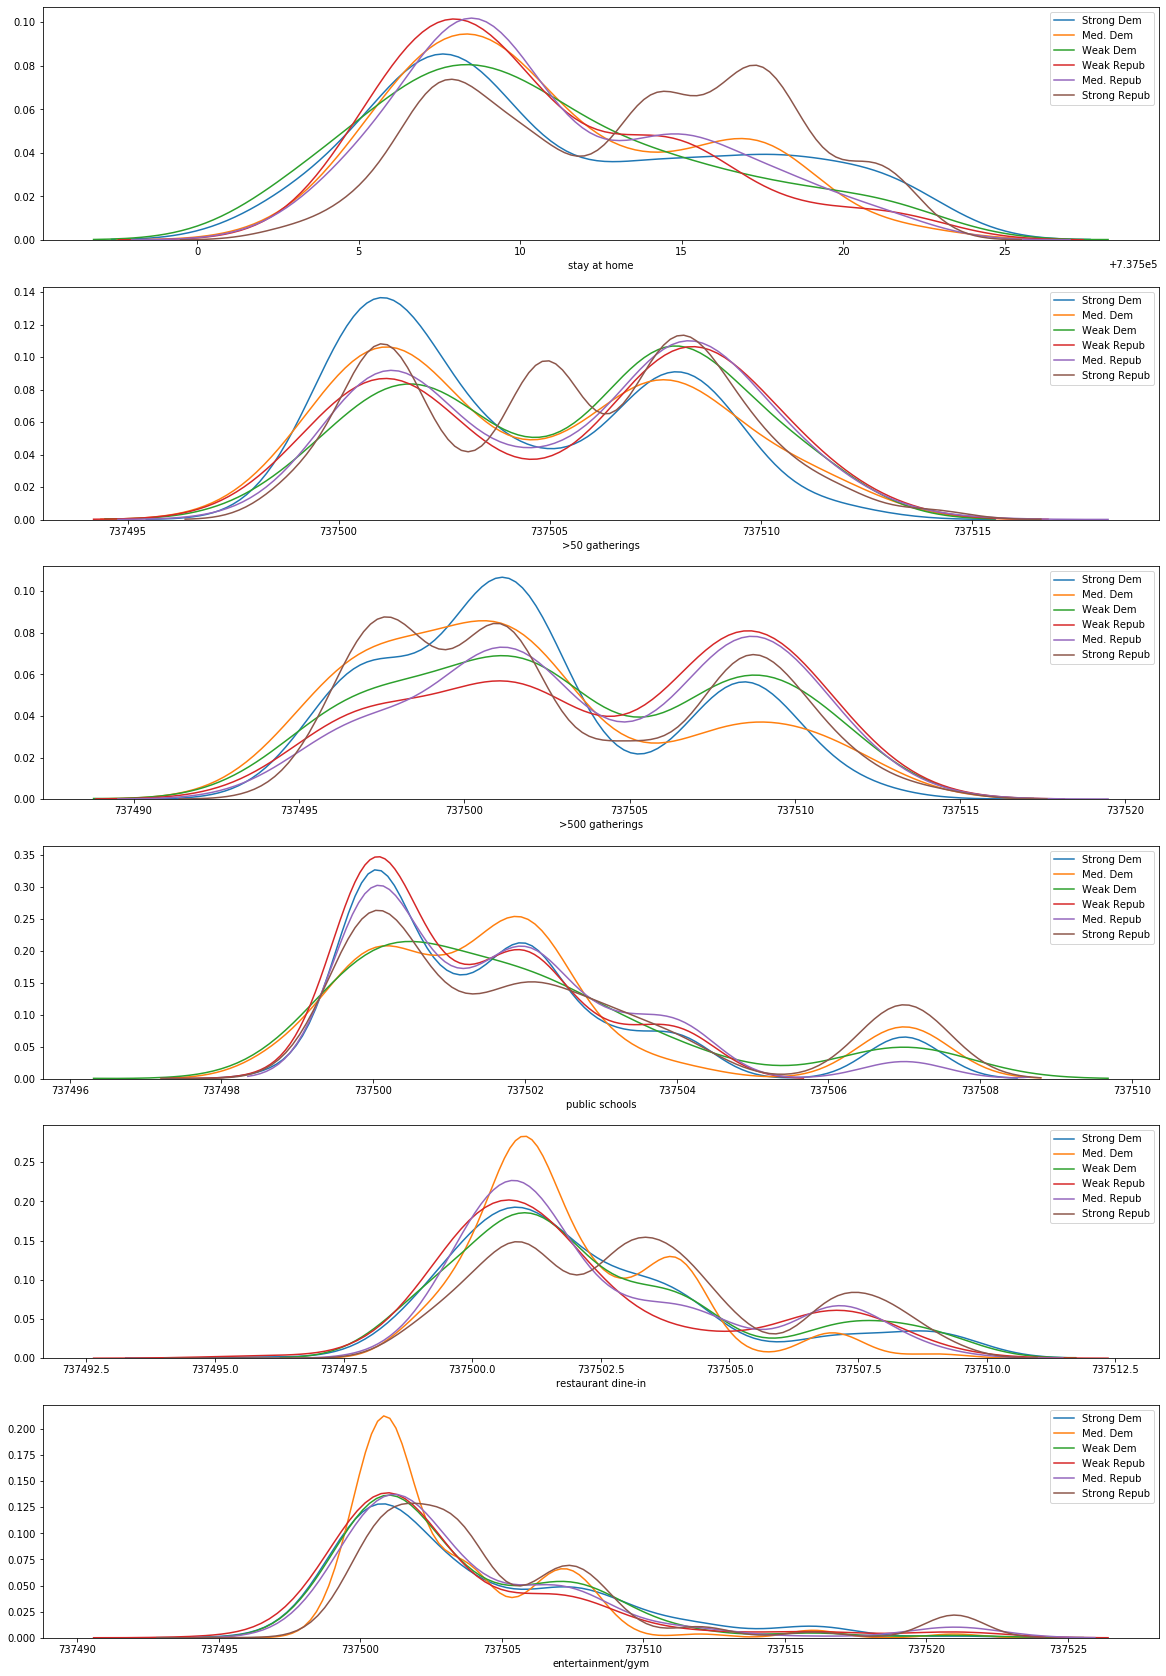

In [8]:
fig, axes = plt.subplots(6, 1, figsize=(20,30))
dist_df = cat_merged.loc[:, ('stay at home', '>50 gatherings',
       '>500 gatherings', 'public schools', 'restaurant dine-in',
       'entertainment/gym', 'Total')].dropna()
columns = dist_df.iloc[:, :-1].columns.tolist()

for ax_position, column in enumerate(columns):
    sns.distplot(dist_df[dist_df['Total'] == 0].loc[:,column], hist=False, label='Strong Dem', ax=axes[ax_position])
    sns.distplot(dist_df[dist_df['Total'] == 1].loc[:,column], hist=False, label='Med. Dem', ax=axes[ax_position])
    sns.distplot(dist_df[dist_df['Total'] == 2].loc[:,column], hist=False, label='Weak Dem', ax=axes[ax_position])
    sns.distplot(dist_df[dist_df['Total'] == 3].loc[:,column], hist=False, label='Weak Repub', ax=axes[ax_position])
    sns.distplot(dist_df[dist_df['Total'] == 4].loc[:,column], hist=False, label='Med. Repub', ax=axes[ax_position])
    sns.distplot(dist_df[dist_df['Total'] == 5].loc[:,column], hist=False, label='Strong Repub', ax=axes[ax_position])
    
plt.legend();

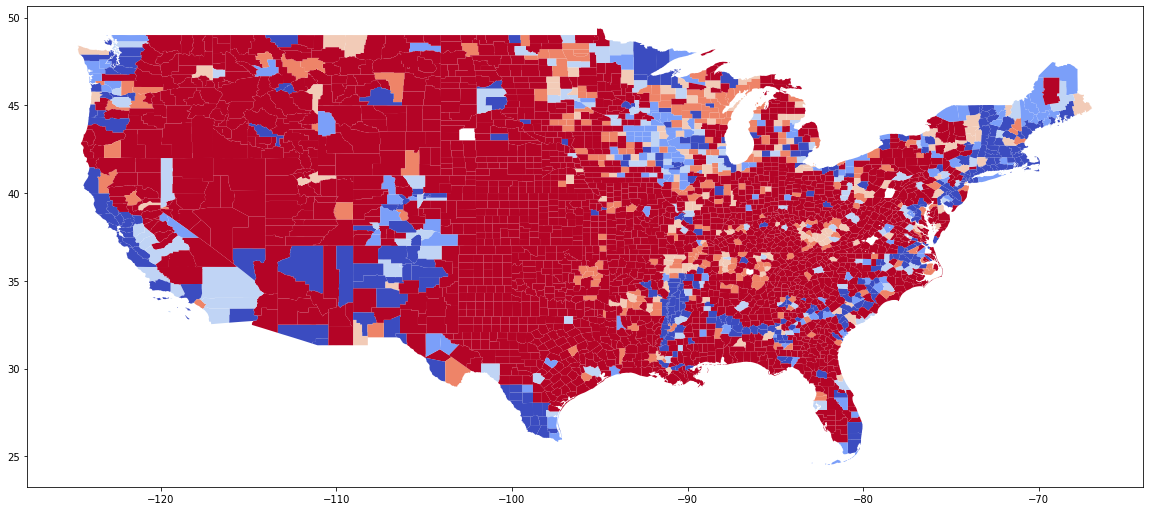

In [9]:
merged_shape_cat = shape.loc[:, ('STATEFP', 'COUNTYFP', 'geometry')].merge(cat_merged.loc[:, ('Total', 'STATEFP', 'COUNTYFP')], 
                                                            on=['STATEFP', 'COUNTYFP']).loc[:, ('Total', 'geometry')]
merged_shape_cat = merged_shape_cat.cx[-130:-50, 20:]

merged_shape_cat.plot(column='Total', cmap='coolwarm', figsize=(20,10), linewidth=0, edgecolor='white');

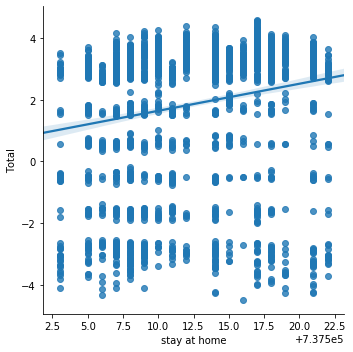

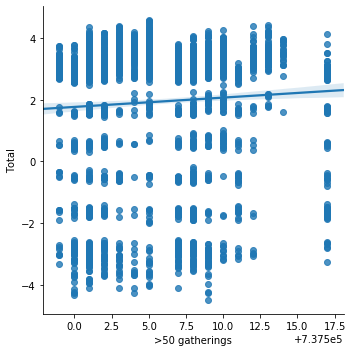

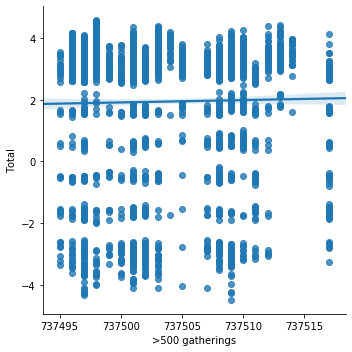

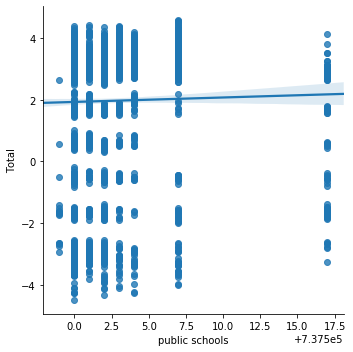

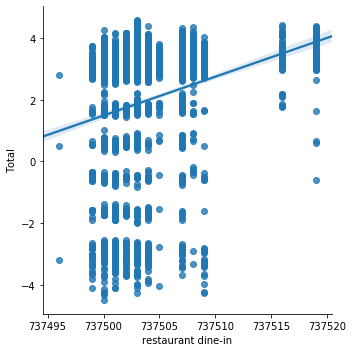

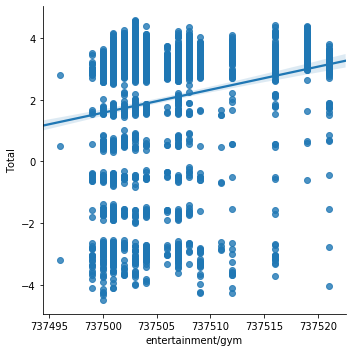

In [10]:
for column in cont_merged.columns.tolist()[75:81]:
    sns.lmplot(column, 'Total', cont_merged)

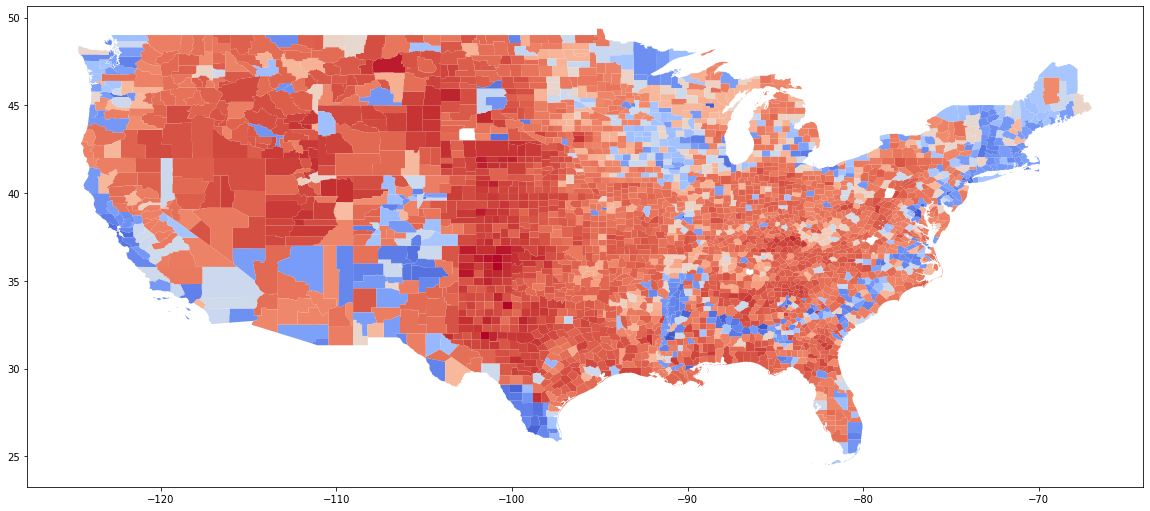

In [11]:
merged_shape_cont = shape.loc[:, ('STATEFP', 'COUNTYFP', 'geometry')].merge(cont_merged.loc[:, ('Total', 'STATEFP', 'COUNTYFP')], 
                                                            on=['STATEFP', 'COUNTYFP']).loc[:, ('Total', 'geometry')]
merged_shape_cont = merged_shape_cont.cx[-130:-50, 20:]

merged_shape_cont.plot(column='Total', cmap='coolwarm', figsize=(20,10), linewidth=0, edgecolor='white');

----

In [14]:
cat_merged

,FIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop,2000,2004,2008,2012,2016,Total
0,1001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,...,0.4354,NaN,NaN,NaN,1,1,1,1,1,5
1,1003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,...,0.2162,NaN,NaN,NaN,1,1,1,1,1,5
2,1005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,...,0.9959,6.08,5400.0,18241.0,0,1,1,0,1,3
3,1007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,...,0.6003,2.75,14980.0,6120.0,1,1,1,1,1,5
4,1009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,...,0.4242,7.21,31850.0,25233.0,1,1,1,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066,56039,56.0,39.0,Teton,WY,Wyoming,43.713556,-110.570974,43.494174,-110.784353,...,0.1127,NaN,NaN,NaN,1,0,0,0,0,1
3067,56041,56.0,41.0,Uinta,WY,Wyoming,41.289323,-110.553036,41.271860,-110.767519,...,0.4522,NaN,NaN,NaN,1,1,1,1,1,5
3068,56043,56.0,43.0,Washakie,WY,Wyoming,43.909060,-107.679282,44.012142,-107.911552,...,0.3732,NaN,NaN,NaN,1,1,1,1,1,5
3069,56045,56.0,45.0,Weston,WY,Wyoming,43.843456,-104.556904,43.910214,-104.312414,...,0.3475,0.44,5250.0,1532.0,1,1,1,1,1,5


In [36]:
presidential_df = pd.read_csv('1976-2016-president.csv')
presidential_df = presidential_df[presidential_df['year'] == 2016]
presidential_df = presidential_df[(presidential_df['party'] == 'republican') | 
                                  (presidential_df['party'] == 'democrat')]
presidential_df.head()

,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party,writein,candidatevotes,totalvotes,version,notes
3395,2016,Alabama,AL,1,63,41,US President,"Trump, Donald J.",republican,False,1318255,2123372,20171015,NaN
3396,2016,Alabama,AL,1,63,41,US President,"Clinton, Hillary",democrat,False,729547,2123372,20171015,NaN
3400,2016,Alaska,AK,2,94,81,US President,"Trump, Donald J.",republican,False,163387,318608,20171015,NaN
3401,2016,Alaska,AK,2,94,81,US President,"Clinton, Hillary",democrat,False,116454,318608,20171015,NaN
3407,2016,Arizona,AZ,4,86,61,US President,"Trump, Donald J.",republican,False,1252401,2573165,20171015,NaN


In [49]:
presidential_df = pd.read_csv('1976-2016-president.csv')
presidential_df = presidential_df[presidential_df['year'] == 2016]
presidential_df = presidential_df[(presidential_df['party'] == 'republican') | 
                                  (presidential_df['party'] == 'democrat')]

winners = presidential_df.groupby('state').apply(lambda state: state['candidate'][state['candidatevotes'].idxmax()]).values
state_winners_df = pd.DataFrame({'State' : presidential_df['state'].unique(),
                                 'StateVotedTrump' : winners})
state_winners_df.loc[:, 'StateVotedTrump'] = (state_winners_df['StateVotedTrump'] ==  'Trump, Donald J.').astype(int)
state_winners_df

,State,StateVotedTrump
0,Alabama,1
1,Alaska,1
2,Arizona,1
3,Arkansas,1
4,California,0
5,Colorado,0
6,Connecticut,0
7,Delaware,0
8,District of Columbia,0
9,Florida,1


In [41]:
winners.apply(lambda x: x)

AttributeError: 'numpy.ndarray' object has no attribute 'apply'

----

### Google Mobility Report (Work in Progress)

In [65]:
mob = pd.read_csv('Global_Mobility_Report.csv')
mob = mob[mob['country_region'] == 'United States'].iloc[:, 2:]
mob.reset_index(inplace=True)
mob.drop(columns='index', inplace=True)
new_cols = ['retail', 'grocery', 'parks', 'transit', 'workplaces', 'residential']
mob.columns = ['State', 'CountyName', 'date'] + new_cols
mob.loc[:, 'CountyName'] = mob.loc[:, 'CountyName'].str.replace(' County', '')
mob.loc[:, 'date_ord'] = pd.to_datetime(mob['date']).map(pd.Timestamp.toordinal)
mob.head()

,State,CountyName,date,retail,grocery,parks,transit,workplaces,residential,date_ord
0,NaN,NaN,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0,737470
1,NaN,NaN,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0,737471
2,NaN,NaN,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0,737472
3,NaN,NaN,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0,737473
4,NaN,NaN,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0,737474


In [66]:
print('Proportion of Missing Data in Google Mobility Report by Column')
pd.pivot_table(mob, index=['State', 'CountyName']).isna().apply(lambda x: x.sum() / len(x))

Proportion of Missing Data in Google Mobility Report by Column


date_ord       0.000000
grocery        0.119546
parks          0.650585
residential    0.443420
retail         0.087265
transit        0.593828
workplaces     0.014544
dtype: float64

In [89]:
mob_merged = cat_merged.merge(pd.pivot_table(mob, index=['State', 'CountyName']), 
                               on=['State', 'CountyName'], how='inner')

no_nan = mob_merged.copy().loc[:, ['stay at home', '>50 gatherings', '>500 gatherings', 'public schools',
       'restaurant dine-in', 'entertainment/gym', 'grocery', 'retail', 'workplaces', 'Total']]
no_nan.dropna(inplace=True)
no_nan = no_nan[(no_nan['Total'] == 0) | (no_nan['Total'] == 5)]
x = no_nan.loc[:, ['stay at home', '>50 gatherings', '>500 gatherings', 'public schools',
       'restaurant dine-in', 'entertainment/gym', 'grocery', 'retail', 'workplaces']]
y = no_nan.loc[:, 'Total']

model = LogisticRegression(solver='lbfgs')
model.fit(x, y)
model.score(x, y)

0.8291424887169568

,FIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,...,2012,2016,Total,date_ord,grocery,parks,residential,retail,transit,workplaces
0,1001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,...,1,1,5,737505.500000,7.222222,-34.000000,8.660000,-11.805556,NaN,-19.416667
1,1003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,...,1,1,5,737505.500000,1.791667,7.680556,6.513889,-16.208333,-8.277778,-17.069444
2,1005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,...,0,1,3,737505.500000,-6.490196,NaN,NaN,1.259259,NaN,-13.069444
3,1007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,...,1,1,5,737505.500000,5.823529,NaN,NaN,0.823529,NaN,-14.875000
4,1009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,...,1,1,5,737505.500000,4.328571,NaN,8.240000,-8.098361,NaN,-17.861111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2665,56039,56.0,39.0,Teton,WY,Wyoming,43.713556,-110.570974,43.494174,-110.784353,...,0,0,1,737505.500000,-16.875000,-32.084507,NaN,-35.474576,-18.108696,-32.597222
2666,56041,56.0,41.0,Uinta,WY,Wyoming,41.289323,-110.553036,41.271860,-110.767519,...,1,1,5,737505.500000,14.352941,NaN,NaN,-4.843137,4.347222,-14.805556
2667,56043,56.0,43.0,Washakie,WY,Wyoming,43.909060,-107.679282,44.012142,-107.911552,...,1,1,5,737503.982759,-12.000000,NaN,NaN,-2.767442,NaN,-18.520000
2668,56045,56.0,45.0,Weston,WY,Wyoming,43.843456,-104.556904,43.910214,-104.312414,...,1,1,5,737504.980769,-7.000000,NaN,NaN,-55.500000,NaN,-23.416667


In [68]:
mob_merged_narrowed = mob_merged.loc[:, (['STATEFP', 'COUNTYFP'] + new_cols)]

### Shape Work

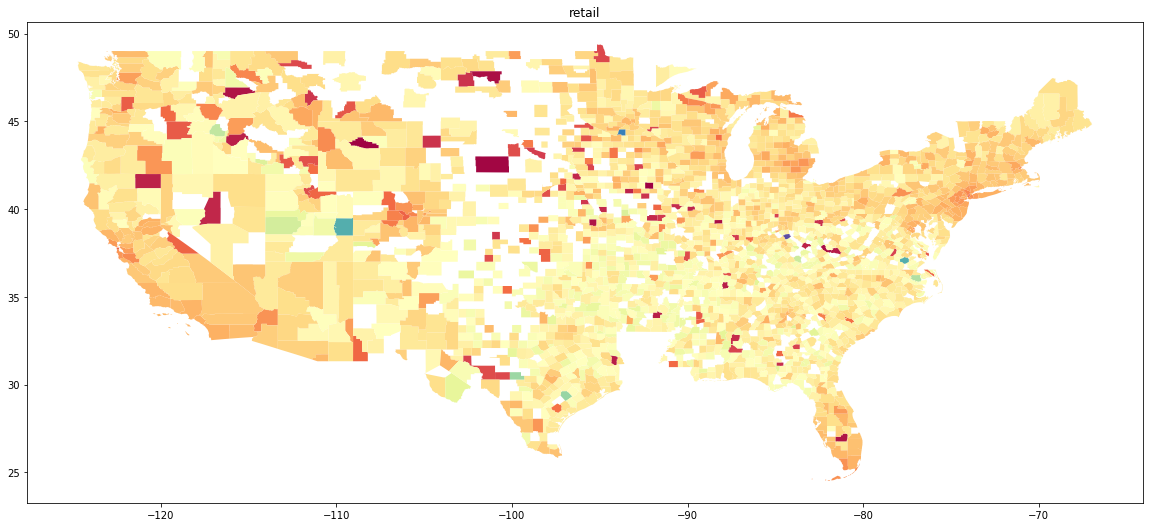

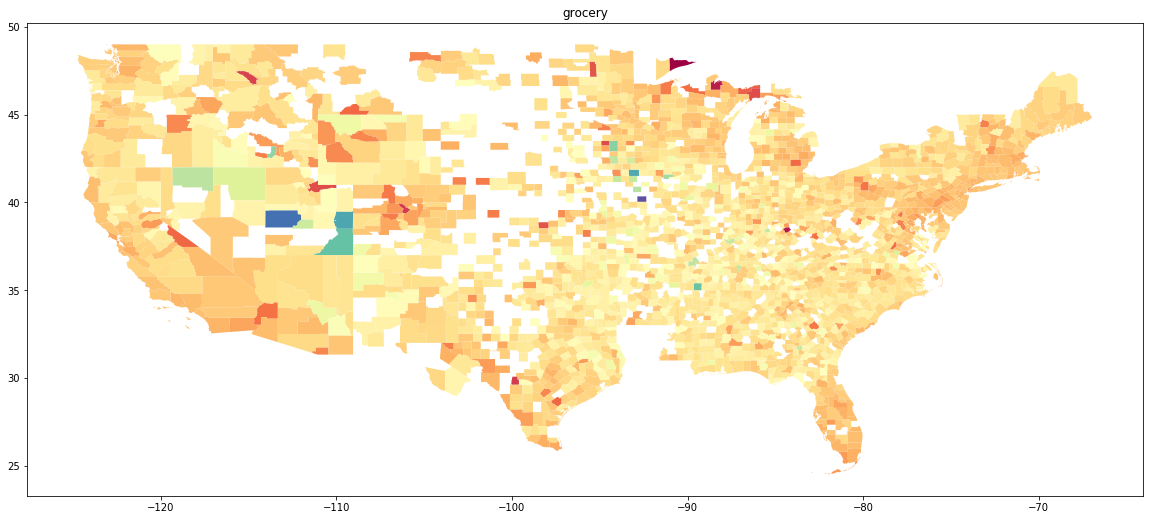

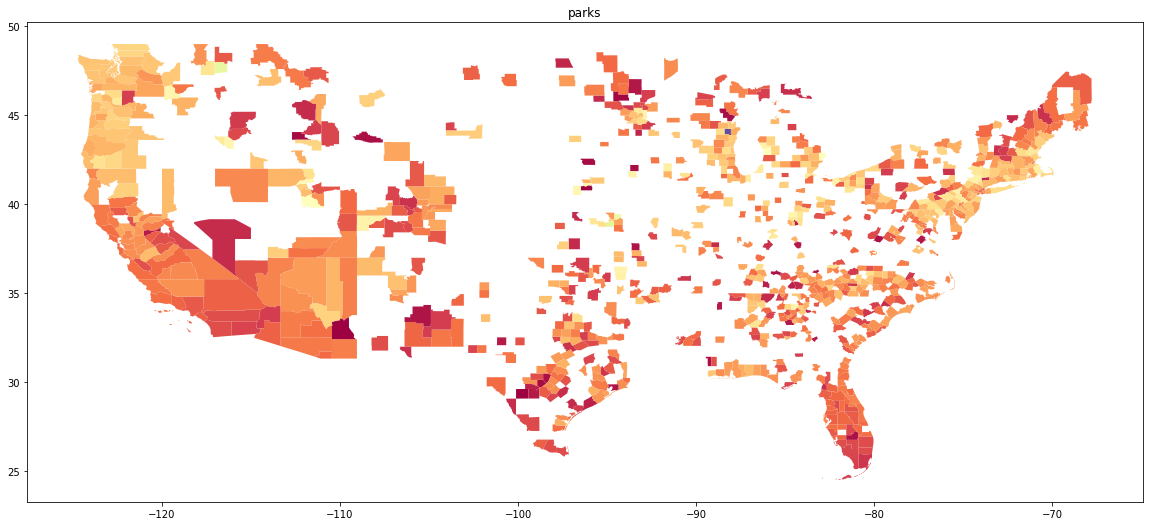

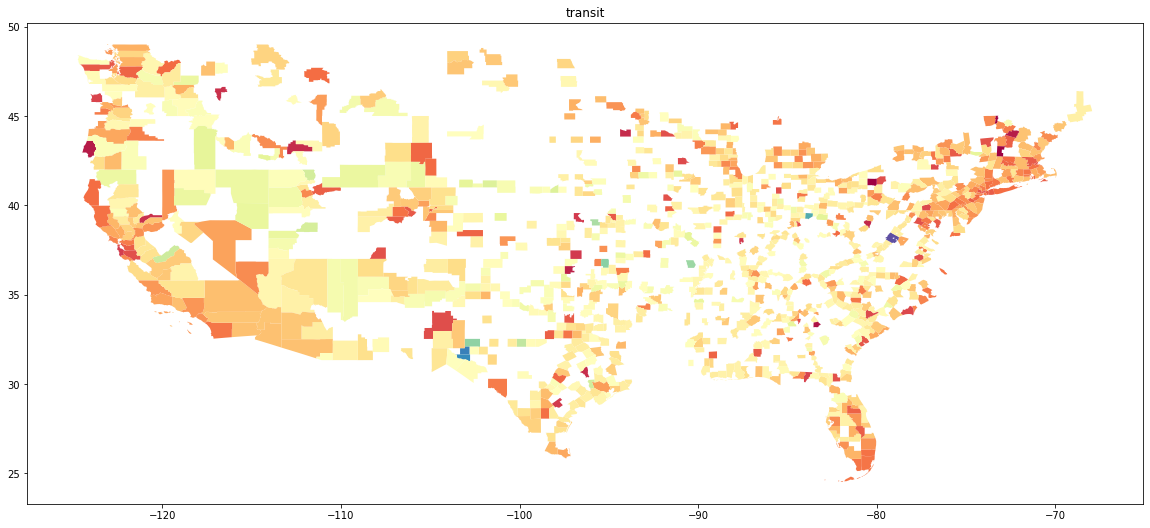

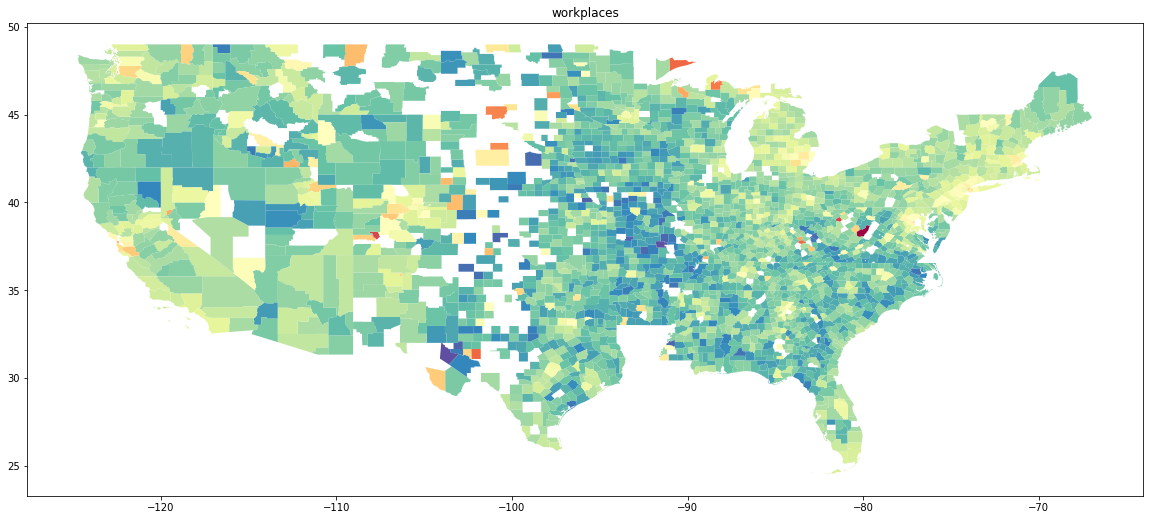

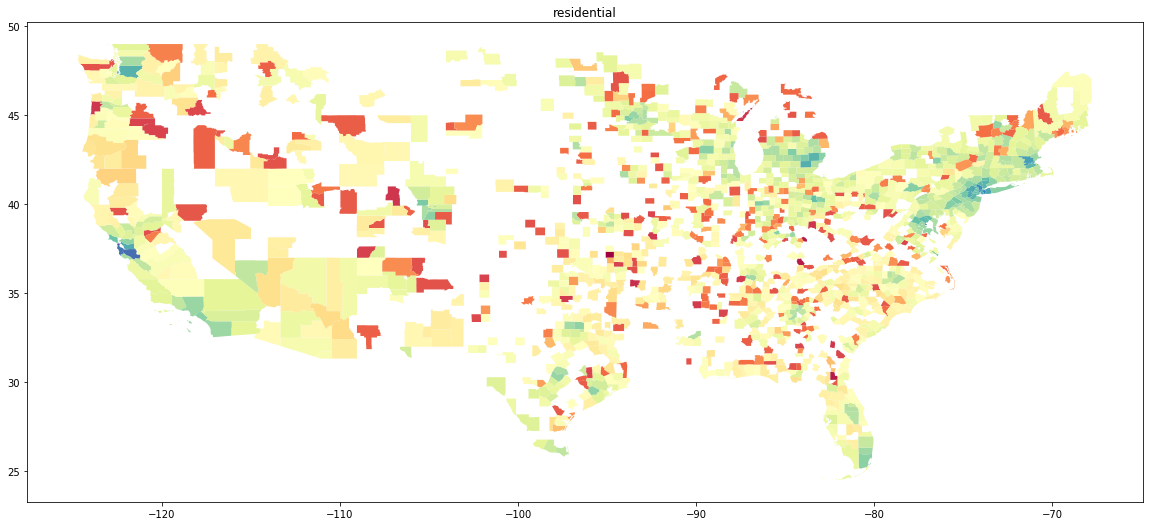

In [69]:
merged_shape_mob = shape.loc[:, ('STATEFP', 'COUNTYFP', 'geometry')].merge(mob_merged_narrowed, 
                                    on=['STATEFP', 'COUNTYFP']).loc[:, (['geometry'] + new_cols)]

merged_shape_mob = merged_shape_mob.cx[-130:-50, 20:50]

for col in new_cols:
    merged_shape_mob.loc[:, ('geometry', col)].dropna().plot(column=col, cmap='Spectral', figsize=(20,10))
    plt.title(col);

In [100]:
merged_shape_mob.loc[:, ('workplaces')] = merged_shape_mob.loc[:, ('workplaces')].interpolate()
merged_shape_mob.loc[:, ('retail')] = merged_shape_mob.loc[:, ('retail')].interpolate()
merged_shape_mob.loc[:, ('grocery')] = merged_shape_mob.loc[:, ('grocery')].interpolate()

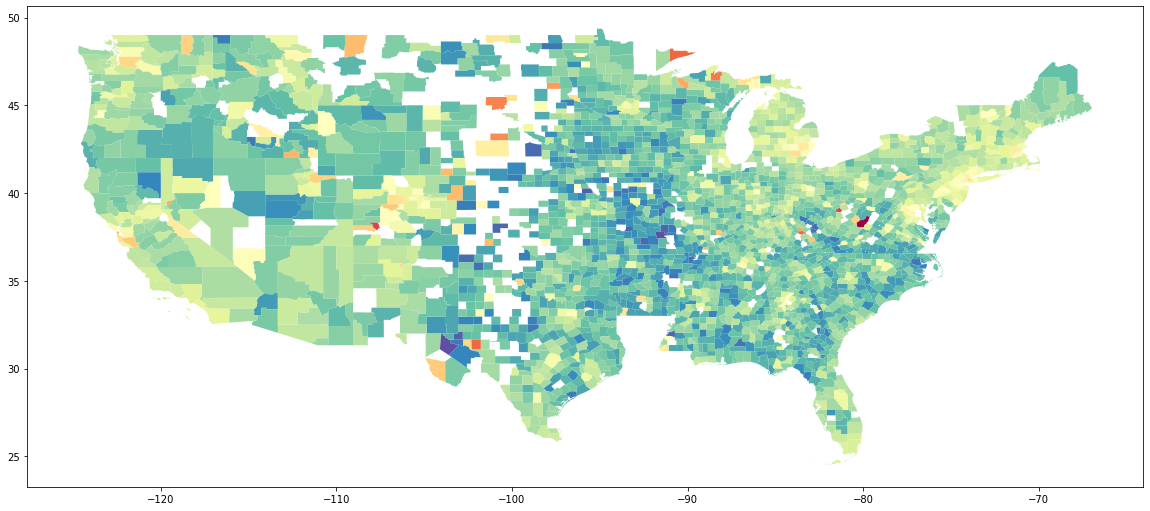

In [106]:
merged_shape_mob.loc[:, ('geometry', 'workplaces')].plot(column='workplaces', cmap='Spectral', figsize=(20,10))

In [105]:
merged_shape_mob['workplaces'].isna().sum()

0

In [72]:
mob_test = mob[mob['State'] == 'Alabama']
mob_test.head()

,State,CountyName,date,retail,grocery,parks,transit,workplaces,residential,date_ord
72,Alabama,NaN,2020-02-15,5.0,2.0,39.0,7.0,2.0,-1.0,737470
73,Alabama,NaN,2020-02-16,0.0,-2.0,-7.0,3.0,-1.0,1.0,737471
74,Alabama,NaN,2020-02-17,3.0,0.0,17.0,7.0,-17.0,4.0,737472
75,Alabama,NaN,2020-02-18,-4.0,-3.0,-11.0,-1.0,1.0,2.0,737473
76,Alabama,NaN,2020-02-19,4.0,1.0,6.0,4.0,1.0,0.0,737474


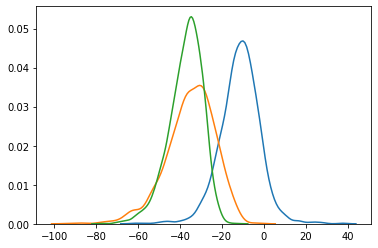

In [73]:
date = 737520
sns.distplot(pd.pivot_table(mob[mob['date_ord'] > date], index=['State', 'CountyName'])['grocery'].dropna().values, hist=False)
sns.distplot(pd.pivot_table(mob[mob['date_ord'] > date], index=['State', 'CountyName'])['retail'].dropna().values, hist=False)
sns.distplot(pd.pivot_table(mob[mob['date_ord'] > date], index=['State', 'CountyName'])['workplaces'].dropna().values, hist=False)

In [74]:
mob_test.iloc[:, 1:].groupby('CountyName').mean()['residential'].isna().sum()

29

In [75]:
mob_test_winst = mob_test[mob_test['CountyName'] == 'Winston']
mob_test_aut = mob_test[mob_test['CountyName'] == 'Autauga']

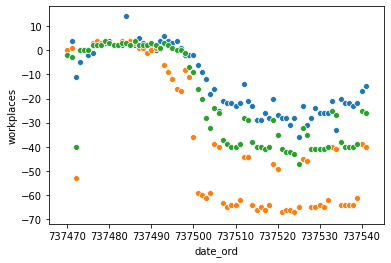

In [76]:
sns.scatterplot('date_ord', 'workplaces', data=mob[(mob['CountyName'] == 'Winston') & (mob['State'] == 'Alabama')])
sns.scatterplot('date_ord', 'workplaces', data=mob[(mob['CountyName'] == 'Alameda') & (mob['State'] == 'California')])
sns.scatterplot('date_ord', 'workplaces', data=mob[(mob['CountyName'] == 'Stanislaus') & (mob['State'] == 'California')])


In [88]:
mob[mob['date_ord'] > 737490]

,State,CountyName,date,retail,grocery,parks,transit,workplaces,residential,date_ord
21,NaN,NaN,2020-03-07,10.0,8.0,29.0,7.0,5.0,-1.0,737491
22,NaN,NaN,2020-03-08,10.0,7.0,40.0,5.0,2.0,-1.0,737492
23,NaN,NaN,2020-03-09,6.0,6.0,31.0,-1.0,0.0,0.0,737493
24,NaN,NaN,2020-03-10,6.0,7.0,18.0,-3.0,-2.0,1.0,737494
25,NaN,NaN,2020-03-11,8.0,10.0,26.0,-2.0,-1.0,0.0,737495
...,...,...,...,...,...,...,...,...,...,...
194375,Wyoming,Weston,2020-04-20,NaN,NaN,NaN,NaN,-38.0,NaN,737535
194376,Wyoming,Weston,2020-04-21,NaN,NaN,NaN,NaN,-35.0,NaN,737536
194377,Wyoming,Weston,2020-04-22,NaN,NaN,NaN,NaN,-33.0,NaN,737537
194378,Wyoming,Weston,2020-04-23,NaN,NaN,NaN,NaN,-34.0,NaN,737538


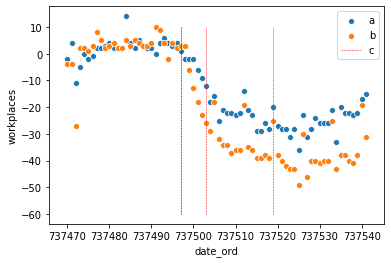

In [78]:
sns.scatterplot('date_ord', 'workplaces', data=mob_test_winst)
sns.scatterplot('date_ord', 'workplaces', data=mob_test_aut)
plt.vlines(737519, -60, 10, color='r', ls='dashed', lw=0.5)
plt.vlines(737503, -60, 10, color='r', ls='dashed', lw=0.5)
plt.vlines(737497, -60, 10, color='r', ls='dashed', lw=0.5)
plt.vlines(737497, -60, 10, color='r', ls='dashed', lw=0.5)
plt.legend(['a', 'b', 'c']);

In [79]:
mob_test_winst['workplaces'].min()

-36.0

In [80]:
abridged[(abridged['CountyName'] == 'Winston') &
         (abridged['State'] == 'Alabama')].loc

In [81]:
Get_County_Orders(abridged, 'Alabama', 'Winston')

NameError: name 'Get_County_Orders' is not defined

In [ ]:
def Get_County_Orders(df, state, county):
    order_columns = ('stay at home', '>50 gatherings', '>500 gatherings', 'public schools',
                     'restaurant dine-in', 'entertainment/gym')
    orders = df[(df['State'] == state) & (df['CountyName'] == county)]
    return orders.loc[:, order_columns]

In [ ]:
mob_test_winst[mob_test_winst['date'] > 737497.0].groupby('CountyName').mean()

In [ ]:
abridged[abridged['State'] == 'Alabama']

In [ ]:
abridged[(abridged['CountyName'] == 'Winston') &
         (abridged['State'] == 'Alabama')].merge(mob_test[mob_test['CountyName'] == 'Winston'],
                                                 on=['State', 'CountyName'])